<figure>
  <IMG SRC="https://raw.githubusercontent.com/pastas/pastas/master/doc/_static/Art_logo.jpg" WIDTH=250 ALIGN="right">
</figure>

# Simulating groundwater levels with a surface water level
*Developed by Raoul Collenteur*

In this example it is shown how to create a time series model with not only evaporation and precipitation, but also including surface water levels. The following data is used:

- groundwater.csv: groundwaterlevels
- rain.csv: Precipitation
- evap.csv: Potential evaporation
- waterlevel.csv: Surface waterlevel

In [1]:
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

%matplotlib notebook

### 1. import and plot the data

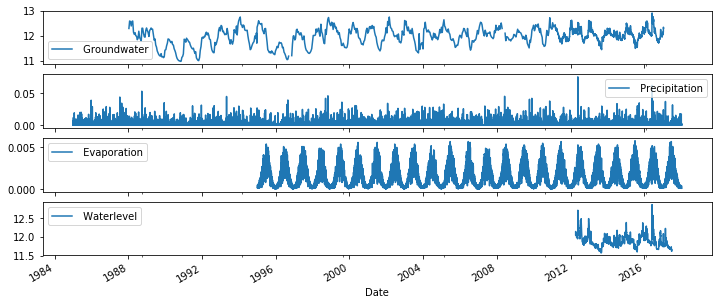

In [2]:
oseries = pd.read_csv("data_notebook_5/groundwater.csv", parse_dates=True, squeeze=True, index_col=0)
rain = pd.read_csv("data_notebook_5/rain.csv", parse_dates=True, squeeze=True, index_col=0)
evap = pd.read_csv("data_notebook_5/evap.csv", parse_dates=True, squeeze=True, index_col=0)
waterlevel = pd.read_csv("data_notebook_5/waterlevel.csv", parse_dates=True, squeeze=True, index_col=0)

fig, axes = plt.subplots(4,1, figsize=(12, 5), sharex=True)
oseries.plot(ax=axes[0], x_compat=True, legend=True)
rain.plot(ax=axes[1], x_compat=True, legend=True)
evap.plot(ax=axes[2], x_compat=True, legend=True)
waterlevel.plot(ax=axes[3], x_compat=True, legend=True)


### 2. Create a timeseries model


INFO: Cannot determine frequency of series  Groundwater
INFO: Time Series  Groundwater: 5 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series  Precipitation: freq=D 
INFO: Inferred frequency from time series  Evaporation: freq=D 
Model Results  Groundwater         Fit Statistics
nfev     33                     EVP         54.70
nobs     2412                   R2           0.55
noise    1                      RMSE         0.15
tmin     2000-01-01 00:00:00    AIC         10.26
tmax     2017-01-16 00:00:00    BIC         44.99
freq     D                      ___              
warmup   3650                   ___              
solver   LeastSquares           ___              

Parameters (6 were optimized)
                optimal   stderr     initial vary
recharge_A   221.973129   ±9.86%  203.104730    1
recharge_n     1.058144   ±1.26%    1.000000    1
recharge_a    37.155199  ±10.83%   10.000000    1
recharge_f    -0.587584  ±13.88%   -1.000000    1

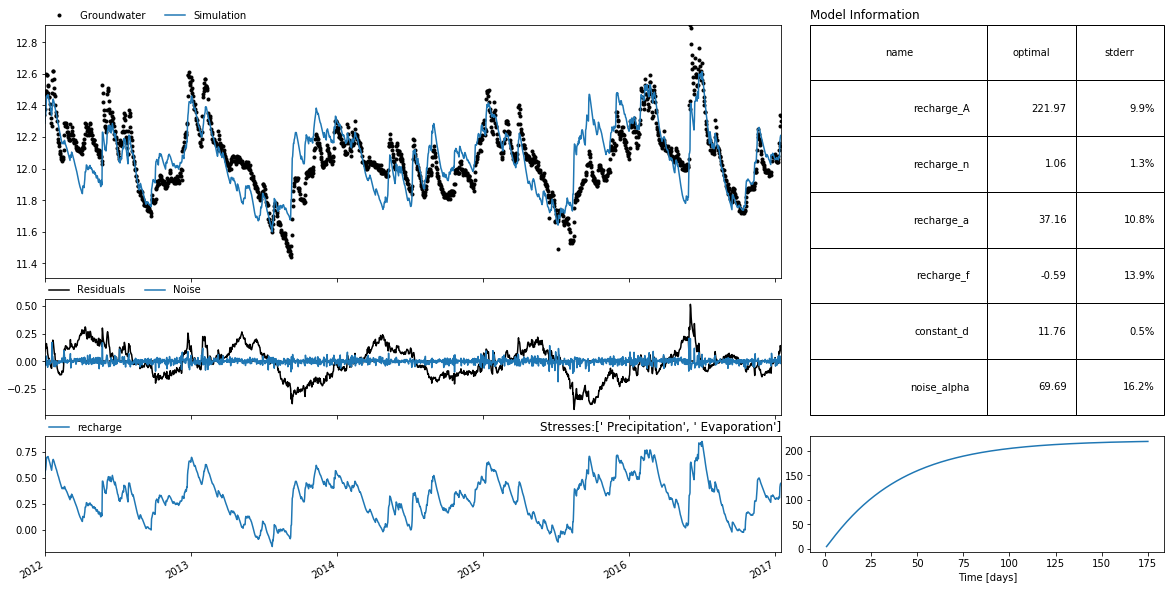

In [3]:
ml = ps.Model(oseries)

sm = ps.StressModel2([rain, evap], rfunc=ps.Gamma, name="recharge")
ml.add_stressmodel(sm)

ml.solve(tmin="2000")
ml.plots.results(tmin="2012", figsize=(16, 8))
print("The explained variance percentage over the period 2012-2017 is: %s" % ml.stats.evp(tmin="2012"))

### 3. Adding surface water level

In [4]:
w = ps.StressModel(waterlevel, rfunc=ps.Exponential,  name="waterlevel", settings="waterlevel")

# Normalize the stress by the mean such that only the variation in the waterlevel matters
w.update_stress(norm="mean")

ml.add_stressmodel(w)
ml.solve(tmin="2012")

INFO: Cannot determine frequency of series  Waterlevel
INFO: Time Series  Waterlevel was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series  Waterlevel was sampled down to freq D with method timestep_weighted_resample
Model Results  Groundwater         Fit Statistics
nfev     45                     EVP         55.93
nobs     1843                   R2           0.56
noise    1                      RMSE         0.15
tmin     2012-01-01 00:00:00    AIC         15.87
tmax     2017-01-16 00:00:00    BIC         60.03
freq     D                      ___              
warmup   3650                   ___              
solver   LeastSquares           ___              

Parameters (8 were optimized)
                optimal   stderr     initial vary
recharge_A    92.292076  ±11.87%  203.104730    1
recharge_n     1.305133   ±2.69%    1.000000    1
recharge_a    16.312369  ±13.09%   10.000000    1
recharge_f    -0.271984  ±60.01%   -1.000000    1
waterlevel_A   0.49709

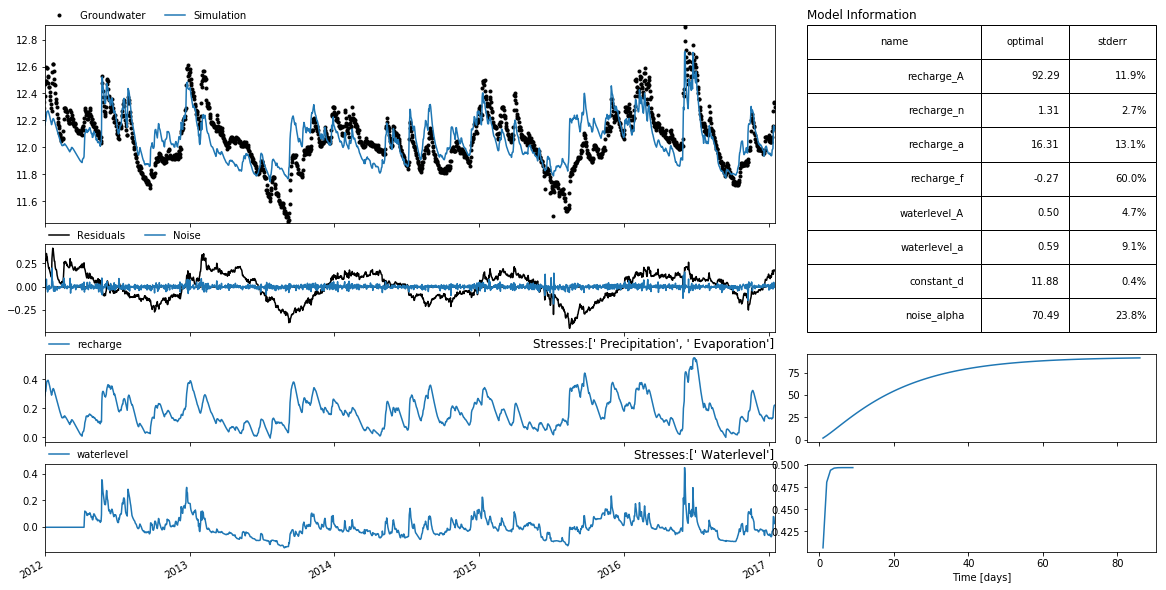

In [5]:
ml.plots.results(figsize=(16, 8))